In [1]:
# -*- coding: utf-8 -*-
import pandas as pd, numpy as np
import json
import collections
from datetime import datetime
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import collections
from sklearn.model_selection import train_test_split

## load data

In [2]:
data = pd.read_csv(
    "https://storage.googleapis.com/covid19-open-data/v2/main.csv",usecols=['key','date', 'subregion1_name','aggregation_level', 'new_confirmed', 'new_deceased', 'new_recovered', 'new_tested', 'total_deceased', 'total_recovered', 
                           'total_hospitalized', 'current_hospitalized', 
                           'population',
                           'population_density', 'human_development_index',
                           'human_capital_index', 'life_expectancy', 
                           'diabetes_prevalence', 'mobility_grocery_and_pharmacy', 
                           'mobility_residential', 'school_closing', 'workplace_closing', 
                           'cancel_public_events', 'restrictions_on_gatherings', 
                           'public_transport_closing', 'stay_at_home_requirements', 
                           'testing_policy', 
                           'contact_tracing','investment_in_vaccines', 
                           'facial_coverings', 
                           'average_temperature',
                           'restrictions_on_internal_movement','international_travel_controls',
                           'public_information_campaigns',
                           'emergency_investment_in_healthcare'
]
    # keep_default_na=False,
    # na_values=[""],
)


# Print a small snippet of the dataset
print(f"The dataset currently contains {len(data)} records, here is a sample:")
data.sample(5)

The dataset currently contains 10882596 records, here is a sample:


,key,date,subregion1_name,aggregation_level,new_confirmed,new_deceased,new_recovered,new_tested,total_deceased,total_recovered,total_hospitalized,current_hospitalized,population,population_density,human_development_index,human_capital_index,life_expectancy,diabetes_prevalence,mobility_grocery_and_pharmacy,mobility_residential,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,average_temperature
4146526,DE_NW_05758,2020-12-28,North Rhine-Westphalia,2,15.0,1.0,14.0,NaN,84.0,5060.0,NaN,NaN,250783.0,558.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.901235
5107669,HT_GA,2021-02-01,Grand'Anse,1,0.0,0.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.541667
8066788,PE_AMA_0403,2020-02-06,Amazonas,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13953.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.244444
6182039,IN_GJ_JMN,2021-01-24,Gujarat,2,6.0,0.0,11.0,0.0,35.0,10348.0,NaN,NaN,2160119.0,NaN,NaN,NaN,NaN,NaN,-12.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.492063
2923918,BR_SP_353560,2020-04-16,São Paulo,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17388.0,NaN,0.771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.722222


In [3]:
# load vaccine data
vacc = pd.read_csv(
    'https://storage.googleapis.com/covid19-open-data/v2/vaccinations.csv')

In [4]:
# age = pd.read_csv(
#     'https://storage.googleapis.com/covid19-open-data/v2/by-age.csv')

## Data cleaning

In [5]:
data_state=data[(data['key'].str.contains("US_"))&(data['aggregation_level']==1)]

Since we have more features on state level than on county level, we will use state level data for prediction.

In [6]:
#filter non-values
data_state= data_state.dropna(thresh=0.1*len(data_state), axis=1)

Merge main with vaccine data

In [7]:
data_vacc=data_state.merge(vacc,on =['key','date'])

In [8]:
data_vacc.head()

,key,date,subregion1_name,aggregation_level,new_confirmed,new_deceased,new_recovered,new_tested,total_deceased,total_recovered,total_hospitalized,current_hospitalized,population,mobility_grocery_and_pharmacy,mobility_residential,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,average_temperature,new_persons_vaccinated,total_persons_vaccinated,new_persons_fully_vaccinated,total_persons_fully_vaccinated,new_vaccine_doses_administered,total_vaccine_doses_administered
0,US_AK,2021-01-12,Alaska,1,294.0,0.0,NaN,9523.0,297.0,NaN,1164.0,79.0,738432.0,-11.0,11.0,3.0,1.0,2.0,4.0,0.0,1.0,2.0,3.0,2.0,3.0,1.0,0.0,0.0,NaN,-10.177778,NaN,22486.0,NaN,5400.0,NaN,35838.0
1,US_AK,2021-01-13,Alaska,1,332.0,1.0,NaN,7856.0,298.0,NaN,1174.0,68.0,738432.0,-8.0,11.0,3.0,1.0,2.0,4.0,0.0,1.0,2.0,3.0,2.0,3.0,1.0,0.0,0.0,NaN,-15.166667,2055.0,24541.0,766.0,6166.0,2842.0,38680.0
2,US_AK,2021-01-14,Alaska,1,291.0,1.0,NaN,7552.0,299.0,NaN,1179.0,81.0,738432.0,-12.0,11.0,3.0,1.0,2.0,4.0,0.0,1.0,2.0,3.0,2.0,3.0,1.0,0.0,0.0,NaN,-14.700000,10967.0,35508.0,0.0,NaN,3916.0,42596.0
3,US_AK,2021-01-15,Alaska,1,195.0,0.0,NaN,7792.0,299.0,NaN,1182.0,77.0,738432.0,-14.0,12.0,3.0,1.0,2.0,4.0,0.0,1.0,2.0,3.0,2.0,3.0,1.0,0.0,0.0,NaN,-11.305556,4038.0,39546.0,3240.0,9406.0,6443.0,49039.0
4,US_AK,2021-01-19,Alaska,1,161.0,1.0,NaN,9383.0,303.0,NaN,1190.0,61.0,738432.0,-14.0,11.0,2.0,1.0,2.0,4.0,0.0,1.0,2.0,3.0,2.0,3.0,1.0,0.0,0.0,NaN,-3.750000,15888.0,55434.0,1396.0,10802.0,17292.0,66331.0


In [9]:
#filter on 50% null values
data_vacc= data_vacc.dropna(thresh=0.5*len(data_vacc), axis=1)

In [10]:
# fill nan values with 0
data_vacc=data_vacc.fillna(0)

Data after cleaning

In [11]:
data_vacc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600 entries, 0 to 5599
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   key                                5600 non-null   object 
 1   date                               5600 non-null   object 
 2   subregion1_name                    5600 non-null   object 
 3   aggregation_level                  5600 non-null   int64  
 4   new_confirmed                      5600 non-null   float64
 5   new_deceased                       5600 non-null   float64
 6   new_tested                         5600 non-null   float64
 7   total_deceased                     5600 non-null   float64
 8   population                         5600 non-null   float64
 9   mobility_grocery_and_pharmacy      5600 non-null   float64
 10  mobility_residential               5600 non-null   float64
 11  school_closing                     5600 non-null   float

## Feature engineering and selection

correlation analysis

In [12]:
# correlation analysis
corr =data_vacc[['new_confirmed',
 'new_deceased',
 'new_tested',
 'total_deceased',
 'population',
 'mobility_grocery_and_pharmacy',
 'mobility_residential',
 'school_closing',
 'workplace_closing',
 'cancel_public_events',
 'restrictions_on_gatherings',
 'public_transport_closing',
 'stay_at_home_requirements',
 'restrictions_on_internal_movement',
 'international_travel_controls',
 'public_information_campaigns',
 'testing_policy',
 'contact_tracing',
 'facial_coverings',
 'average_temperature',
 'new_persons_vaccinated',
 'total_persons_vaccinated',
 'new_persons_fully_vaccinated',
 'total_persons_fully_vaccinated',
 'new_vaccine_doses_administered',
 'total_vaccine_doses_administered']].corr()
features = corr['new_confirmed'].sort_values(ascending=False)
print(features)

new_confirmed                        1.000000
population                           0.643070
new_tested                           0.603382
total_deceased                       0.579939
new_deceased                         0.557597
new_persons_vaccinated               0.403238
new_vaccine_doses_administered       0.369995
school_closing                       0.303997
new_persons_fully_vaccinated         0.283475
mobility_residential                 0.281253
total_persons_vaccinated             0.273496
total_vaccine_doses_administered     0.250076
stay_at_home_requirements            0.242595
workplace_closing                    0.232184
restrictions_on_gatherings           0.227648
total_persons_fully_vaccinated       0.197260
restrictions_on_internal_movement    0.177079
international_travel_controls        0.154234
public_information_campaigns         0.152315
cancel_public_events                 0.137268
testing_policy                       0.099020
contact_tracing                   

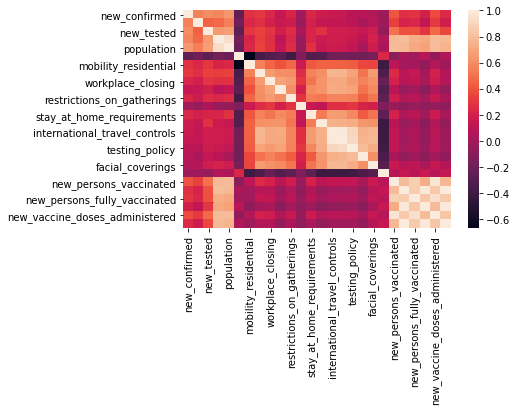

In [13]:
sns.heatmap(corr)

In [14]:
features

new_confirmed                        1.000000
population                           0.643070
new_tested                           0.603382
total_deceased                       0.579939
new_deceased                         0.557597
new_persons_vaccinated               0.403238
new_vaccine_doses_administered       0.369995
school_closing                       0.303997
new_persons_fully_vaccinated         0.283475
mobility_residential                 0.281253
total_persons_vaccinated             0.273496
total_vaccine_doses_administered     0.250076
stay_at_home_requirements            0.242595
workplace_closing                    0.232184
restrictions_on_gatherings           0.227648
total_persons_fully_vaccinated       0.197260
restrictions_on_internal_movement    0.177079
international_travel_controls        0.154234
public_information_campaigns         0.152315
cancel_public_events                 0.137268
testing_policy                       0.099020
contact_tracing                   

In [15]:
data_vacc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600 entries, 0 to 5599
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   key                                5600 non-null   object 
 1   date                               5600 non-null   object 
 2   subregion1_name                    5600 non-null   object 
 3   aggregation_level                  5600 non-null   int64  
 4   new_confirmed                      5600 non-null   float64
 5   new_deceased                       5600 non-null   float64
 6   new_tested                         5600 non-null   float64
 7   total_deceased                     5600 non-null   float64
 8   population                         5600 non-null   float64
 9   mobility_grocery_and_pharmacy      5600 non-null   float64
 10  mobility_residential               5600 non-null   float64
 11  school_closing                     5600 non-null   float

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(
#     data_vacc.drop(labels=['key', 'date','subregion1_name','aggregation_level','new_confirmed' ], axis=1),
#     data_vacc['new_confirmed'],
#     test_size=0.3,
#     random_state=42)
# X_train.shape, X_test.shape

Feature improtance from lasso

In [17]:
x= data_vacc.drop(labels=['key', 'date','subregion1_name','aggregation_level','new_confirmed' ], axis=1)
y=data_vacc['new_confirmed']

In [18]:
scaler = StandardScaler()
# fit and transform the data
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns = x.columns)

In [19]:
las = LassoCV()
las.fit(x_scaled, y)
coef = pd.Series(las.coef_, index = x.columns)

In [20]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 24 variables and eliminated the other 1 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

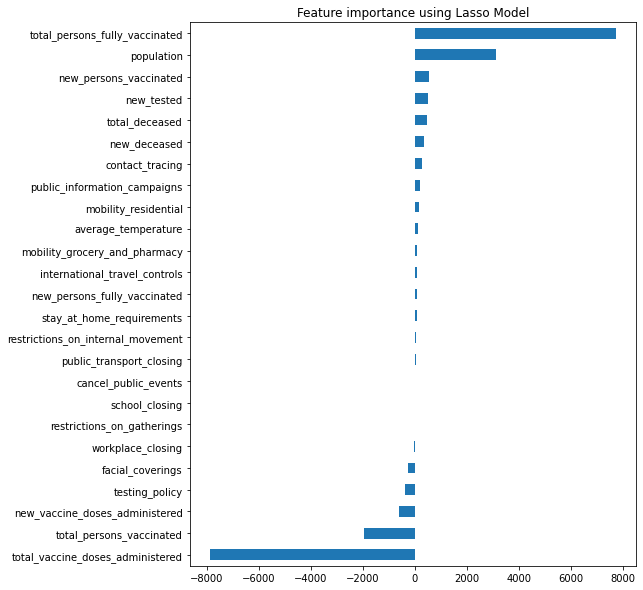

In [21]:
imp_coef = coef.sort_values()
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

feature importance from xgboost

[00:13:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.6047195  0.02751637 0.00430798 0.04818324 0.00522612 0.00508432
 0.19653411 0.00842704 0.00723625 0.00565997 0.00999014 0.00665342
 0.00661303 0.         0.00399765 0.00626923 0.00442762 0.0049843
 0.00752253 0.00385829 0.01432021 0.00337166 0.00389567 0.00327817
 0.00792316]


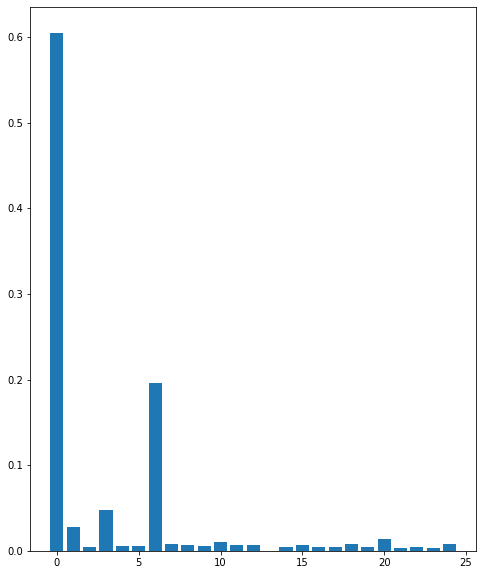

In [22]:
from xgboost import XGBClassifier
Xgb = XGBClassifier()
Xgb.fit(x_scaled, y)
# feature importance
print(Xgb.feature_importances_)
plt.bar(range(len(Xgb.feature_importances_)), Xgb.feature_importances_)
plt.show()

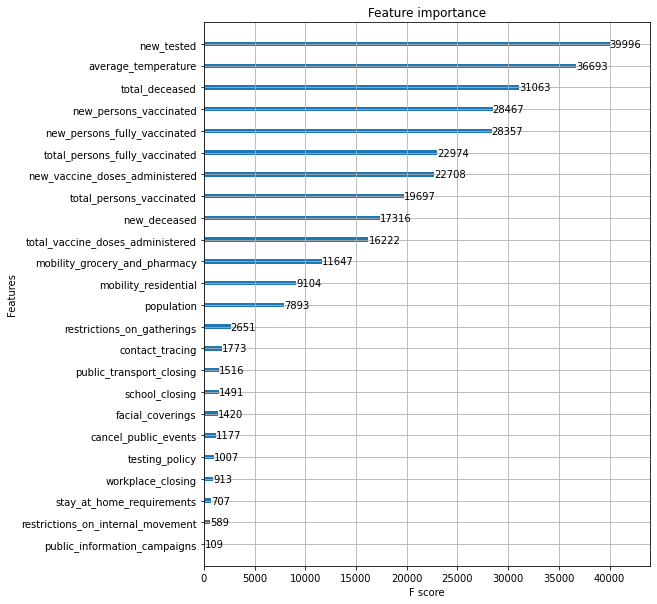

In [23]:
from xgboost import plot_importance
plot_importance(Xgb)
plt.show()

### We tried to view the result from lasso and xgboost using random spilt data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    data_vacc.drop(labels=['key', 'date','subregion1_name','aggregation_level','new_confirmed' ], axis=1),
    data_vacc['new_confirmed'],
    test_size=0.3,
    random_state=42)

In [25]:
scaler = StandardScaler()
# fit and transform the data
x_train_scaled = scaler.fit_transform(X_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns = X_train.columns)

Best alpha using built-in LassoCV: 1.913033
Best score using built-in LassoCV: 0.716885


Text(0.5, 1.0, 'Feature importance using Lasso Model')

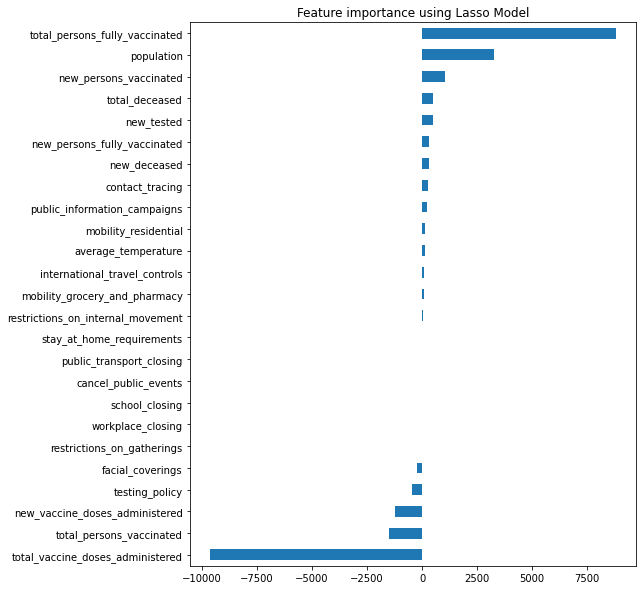

In [26]:
las2 = LassoCV()
las2.fit(x_train_scaled, y_train)
print("Best alpha using built-in LassoCV: %f" %las2.alpha_)
print("Best score using built-in LassoCV: %f" %las2.score(x_train_scaled,y_train))
coef = pd.Series(las2.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

[00:23:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


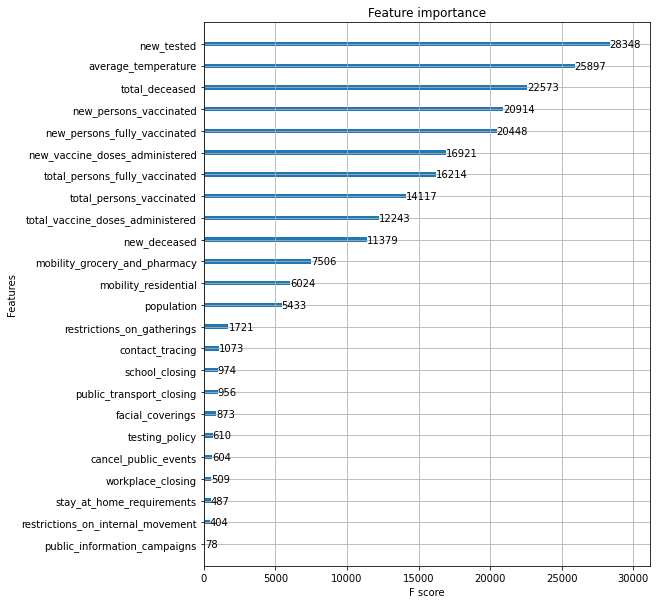

In [27]:
from xgboost import XGBClassifier
Xgb2 = XGBClassifier()
Xgb2.fit(x_train_scaled, y_train)
from xgboost import plot_importance
plot_importance(Xgb2)
plt.show()

### We combined our observation and choose the top 8 features that top performs all methods(correlation, lasso, xgboost) 

In [28]:
new_features = ['new_tested','average_temperature','total_deceased','new_persons_fully_vaccinated','total_persons_fully_vaccinated','new_vaccine_doses_administered','population','new_confirmed']

In [29]:
data_final = data_vacc[new_features]

In [30]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600 entries, 0 to 5599
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   new_tested                      5600 non-null   float64
 1   average_temperature             5600 non-null   float64
 2   total_deceased                  5600 non-null   float64
 3   new_persons_fully_vaccinated    5600 non-null   float64
 4   total_persons_fully_vaccinated  5600 non-null   float64
 5   new_vaccine_doses_administered  5600 non-null   float64
 6   population                      5600 non-null   float64
 7   new_confirmed                   5600 non-null   float64
dtypes: float64(8)
memory usage: 393.8 KB


##  Build machine learning models

In [31]:
# train test spilt
x_train, x_test, y_train, y_test = train_test_split(
    data_final.drop(labels=['new_confirmed' ], axis=1),
    data_final['new_confirmed'],
    test_size=0.3,
    random_state=4)

scaler = StandardScaler()

normalized_x_train = pd.DataFrame(scaler.fit_transform(x_train))
normalized_x_test = pd.DataFrame(scaler.transform(x_test))

In [32]:
#lasso model
clf_lasso = LassoLarsIC(fit_intercept=True, normalize=True, copy_X=True)
clf_lasso.fit(normalized_x_train,  y_train)
test_predict_la= clf_lasso.predict(normalized_x_test)
rmse_lasso=mean_squared_error(y_test,test_predict_la)

#ridge model
clf_ridge = RidgeCV(fit_intercept=True, normalize=True)
clf_ridge.fit(normalized_x_train,  y_train)
test_predict_ri= clf_ridge.predict(normalized_x_test)
rmse_ridge=mean_squared_error(y_test,test_predict_ri)

#RF model
clf_rf = RandomForestRegressor(n_estimators=100,random_state=1337,max_depth=13,min_samples_leaf=2,verbose=0)
clf_rf.fit(normalized_x_train,  y_train)
test_predict_rf= clf_rf.predict(normalized_x_test)
rmse_rf=mean_squared_error(y_test,test_predict_rf)

#GradientBoostingRegressor
clf_GBR = GradientBoostingRegressor(random_state = 1337,verbose = 0,n_estimators = 100,learning_rate = 0.1,loss = 'ls',max_depth = 3)
clf_GBR.fit(normalized_x_train, y_train)
test_predict_GBR= clf_GBR.predict(normalized_x_test)
rmse_GBR=mean_squared_error(y_test,test_predict_GBR)

In [33]:
# select the best model based on rmse
current_score = rmse_lasso
best_model=clf_lasso
for model in [clf_lasso,clf_ridge,clf_rf,clf_GBR]:
    if mean_squared_error(y_test,model.predict(normalized_x_test)) < current_score:
        best_model= model
        current_score = mean_squared_error(y_test,best_model.predict(normalized_x_test))

r2=r2_score(y_test,best_model.predict(normalized_x_test))

In [34]:
best_model.predict(normalized_x_test)

array([10761.51692857,  4352.22918347,  3384.61185157, ...,
        2830.27550794,   180.71143611,  2954.52472375])

In [35]:
y_test

3723    10025.0
4784     2647.0
3427     3656.0
3513      672.0
4810      859.0
         ...   
3042     2643.0
2709        0.0
575      3843.0
2938      230.0
1688     3549.0
Name: new_confirmed, Length: 1680, dtype: float64

In [36]:
best_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=13, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1337, verbose=0, warm_start=False)

### Tuning parameters for RF models using GridSearch

In [37]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
gs_rf = RandomForestRegressor(random_state=1337,n_jobs=-1)


params = [{"n_estimators": [50,100,150,200], "min_samples_leaf": [1, 2, 4, 8, 16], "max_depth": [3, 6, 9,12,15]}]

cv = GridSearchCV(gs_rf, param_grid=params, n_jobs=-1)
cv.fit(normalized_x_train,  y_train)
predicted_y = cv.predict(normalized_x_test)
print(cv.best_params_)


{'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 200}


### Get the r2 result for our best model

In [38]:
r2=r2_score(y_test,predicted_y)
print(r2)

0.8874879267155849


### Plot daily cases in country level 

In [39]:
data_plot = data_vacc[['date','new_confirmed']].groupby('date').sum().reset_index().set_index('date')
data_plot = data_plot[data_plot.index>='2021-03-01']

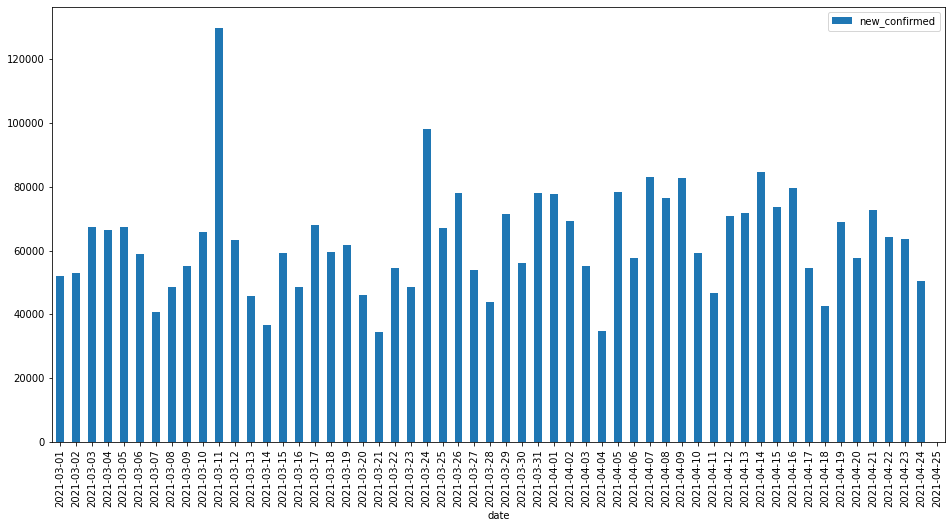

In [40]:
ax = data_plot.plot(kind='bar', figsize=(16, 8))

In [41]:
# do predicts on past 5 days
date1 = '2021-04-20'
date2= '2021-04-24'
data_pre = data_vacc[(data_vacc.date>=date1)&(data_vacc.date<=date2)]

In [42]:
data_pre2 =data_pre[['new_tested','average_temperature','total_deceased','new_persons_fully_vaccinated','total_persons_fully_vaccinated','new_vaccine_doses_administered','population']]
x_predict = pd.DataFrame(scaler.transform(data_pre2))

In [43]:
predicted_y = cv.predict(x_predict)

In [44]:
data_prec = pd.DataFrame(predicted_y.tolist(), index=data_pre.date,columns = ['predict_cases'])

In [45]:
data_1 = data_prec.groupby('date').sum()

In [46]:
a=data_plot.reset_index().merge(data_1.reset_index(), on='date',how = 'left').set_index('date')

## comparison between our result and the ground truth

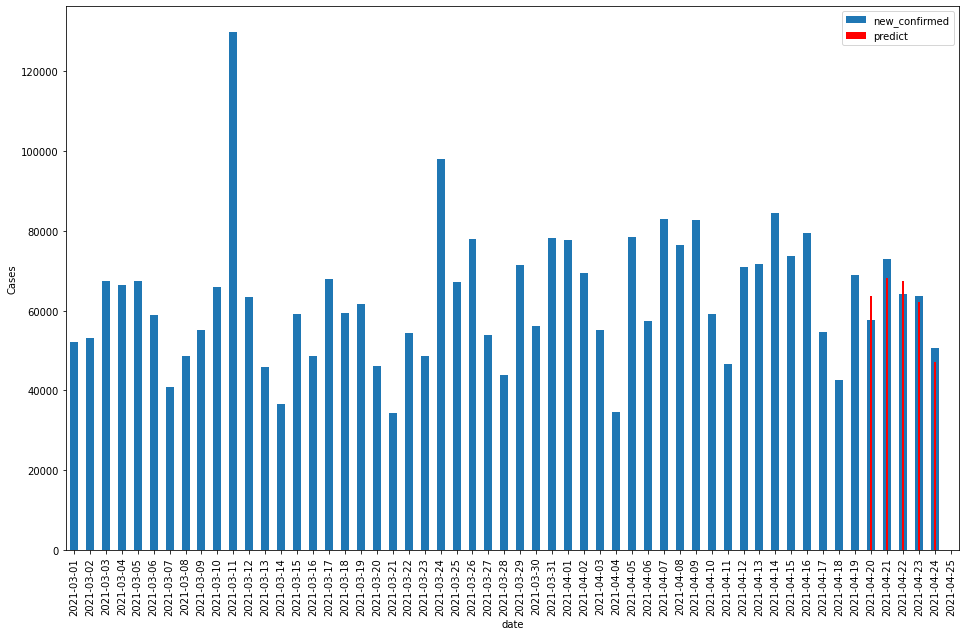

In [47]:
ax = a['new_confirmed'].plot(kind='bar', figsize=(16, 10))
ax.bar(a.index,a['predict_cases'],color='red', label='predict',width = 0.1)
ax.set_ylabel('Cases')
ax.legend();